# mimic

https://github.com/nhsx/SynthVAE/blob/main/MIMIC_preproc.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from random import randrange, seed
from tqdm import tqdm

In [ ]:
mimic_path = "../content/drive/MyDrive/DAHS LAB/" # Path containing MIMIC data
output_path = "../outputs/" # Path to save the created datasets

admissions = pd.read_csv(mimic_path + "admissions.csv.gz")
chartevents = pd.read_csv(mimic_path + "chartevents.csv.gz", nrows=10000000)
icustays = pd.read_csv(mimic_path + "icustays.csv.gz")
d_items = pd.read_csv(mimic_path + "d_items.csv.gz")
outputevents = pd.read_csv(mimic_path + "outputevents.csv.gz")
patients = pd.read_csv(mimic_path + "patients.csv.gz")

In [ ]:
# Replace NaN values with a default date or remove the rows
patients['dod'] = patients['dod'].fillna('2021-12-01') # Or use another appropriate date

# Convert the 'dod' column to datetime, coercing errors to NaT
patients['dod'] = pd.to_datetime(patients['dod'], format='%Y-%m-%d', errors='coerce')

# Filter out rows where 'dod' is NaT if necessary
patients = patients.dropna(subset=['dod'])

# Continue with your processing...


In [ ]:
seed(2021)
## Augment patient DOBs
new_dobs = []
dob_offset = []
for index, row in tqdm(patients.iterrows(), total=patients.shape[0]):
    years_diff_behind = len(
        pd.date_range(
            start=pd.to_datetime(row["dod"], format="%Y-%m-%d"),
            end=pd.to_datetime("2021-12-01", format="%Y-%m-%d"),
            freq="Y",
        )
    )
    years_diff_ahead = len(
        pd.date_range(
            start=pd.to_datetime("2021-12-01", format="%Y-%m-%d"),
            end=pd.to_datetime(row["dod"], format="%Y-%m-%d"),
            freq="Y",
        )
    )

    if (years_diff_behind != 0) and (
        pd.to_datetime(row["dod"], format="%Y-%m-%d")
        < pd.to_datetime("1930-01-01", format="%Y-%m-%d")
    ):
        num_years = randrange(years_diff_behind - 80, years_diff_behind - 40)
        new_dobs.append(
            pd.to_datetime(row["dod"], format="%Y-%m-%d")
            + pd.DateOffset(years=num_years)
        )
        dob_offset.append(num_years)
    elif (years_diff_ahead != 0) and (
        pd.to_datetime(row["dod"], format="%Y-%m-%d")
        > pd.to_datetime("2021-12-01", format="%Y-%m-%d")
    ):
        num_years = randrange(years_diff_ahead + 30, years_diff_ahead + 50)
        new_dobs.append(
            pd.to_datetime(row["dod"], format="%Y-%m-%d")
            - pd.DateOffset(years=num_years)
        )
        dob_offset.append(-num_years)
    else:
        new_dobs.append(pd.to_datetime(row["dod"], format="%Y-%m-%d"))
        dob_offset.append(0)
patients["dod"] = new_dobs
patients["dod_offset"] = dob_offset

  0%|          | 1/299712 [00:00<2:18:10, 36.15it/s]


ValueError: Neither `start` nor `end` can be NaT

In [ ]:
seed(2021)
# Generate mid-sized input file
mimic_table = admissions[['subject_id','race','admittime','dischtime','discharge_location']]
mimic_table = mimic_table.merge(patients[['subject_id','gender','dod']])
mimic_table = mimic_table.merge(icustays[['subject_id','stay_id','first_careunit']])
# mimic_table = mimic_table.merge(outputevents, on=['subject_id', 'stay_id', 'itemid'], how='left')

total_subjects = list(chartevents.subject_id.unique())

df_list = []

split_one = int(np.round(len(total_subjects)*0.3,0))
split_two = int(np.round(len(total_subjects)*0.9,0))

for sub_index in range(0,split_one):
    search_id = total_subjects[sub_index]
    df_list.append(chartevents[chartevents.subject_id == int(search_id)].head(1))

for sub_index in range(split_one,split_two):
    search_id = total_subjects[sub_index]
    df_list.append(chartevents[chartevents.subject_id == int(search_id)].head(2))

for sub_index in range(split_two,len(total_subjects)):
    search_id = total_subjects[sub_index]
    df_list.append(chartevents[chartevents.subject_id == int(search_id)].head(100))

one_per_pat = pd.concat(df_list)
one_per_pat.shape


In [ ]:
mimic_table = mimic_table.merge(one_per_pat[['subject_id','stay_id','charttime','itemid','value','valueuom']],on=['subject_id','stay_id'])

new_admits = []
new_dischs = []
new_chart = []

patient_stays = mimic_table[['subject_id','subject_id','dod','admittime']]
patient_stays.drop_duplicates(inplace=True)

for index, row in tqdm(mimic_table.iterrows(), total=mimic_table.shape[0]):
    admit_min = len(pd.date_range(start=pd.to_datetime(row['dod'],format='%Y-%m-%d'),end=pd.to_datetime('2021-12-01 00:00:00',format='%Y-%m-%d %H:%M:%S'),freq='D'))
    stay_len = len(pd.date_range(start=pd.to_datetime(row['admittime'],format='%Y-%m-%d'),end=pd.to_datetime(row['dischtime'],format='%Y-%m-%d %H:%M:%S'),freq='S'))

    num_days_admit = randrange(np.round(admit_min*0.25,0),np.round(admit_min*0.9,0)+5)
    num_days_disch = randrange(0,50)
    num_secs_chart = randrange(np.round(stay_len*0.01,0)+1,np.round(stay_len*0.99,0)+10)
    new_admit_date = pd.to_datetime(row['dod'],format='%Y-%m-%d') + pd.DateOffset(days=num_days_admit)
    new_admits.append(new_admit_date)
    new_dischs.append(new_admit_date + pd.DateOffset(days=num_days_disch))
    new_chart.append(new_admit_date + pd.DateOffset(seconds=num_secs_chart))

mimic_table['admittime'] = new_admits
mimic_table['dischtime'] = new_dischs
mimic_table['charttime'] = new_chart

In [ ]:
mimic_table = mimic_table[(pd.to_datetime(mimic_table.admittime) < pd.to_datetime(mimic_table.charttime)) & (pd.to_datetime(mimic_table.dischtime) > pd.to_datetime(mimic_table.charttime))]
mimic_table = mimic_table.merge(d_items[['itemid','label']],on=['itemid'])
mimic_table.drop(['stay_id','itemid'],axis=1,inplace=True)
age_calc = pd.Timestamp('2021-12-01')
mimic_table['dod'] = pd.to_datetime(mimic_table['dod'], format='%Y-%m-%d')
mimic_table['age'] = (age_calc - mimic_table['dod']).astype('<m8[Y]')
#mimic_table.to_csv(output_path + "table_one_{}.csv".format(mimic_table.shape[0]), index=False)
print(f"Mid sized input table saved, number of columns:  {mimic_table.shape[1]}, number of rows: {mimic_table.shape[0]}")

In [ ]:
print(f"Mid sized input table saved, number of columns:  {mimic_table.shape[1]}, number of rows: {mimic_table.shape[0]}")

In [ ]:
mimic_table

# MIMIC-IV
- In-Hospital Mortality
- 환자가 입원하는 동안 사망할 것인지 예측하는 모델


## 1. Data Load

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
mimic_path = "../content/drive/MyDrive/DAHS LAB/" # Path containing MIMIC data

admits = pd.read_csv(mimic_path + "admissions.csv.gz")
icustays = pd.read_csv(mimic_path + "icustays.csv.gz")
patients = pd.read_csv(mimic_path + "patients.csv.gz")
diag_icds = pd.read_csv(mimic_path + "diagnoses_icd.csv.gz")

#chartevents = pd.read_csv(mimic_path + "chartevents.csv.gz", nrows=10000000)
#d_items = pd.read_csv(mimic_path + "d_items.csv.gz")
#outputevents = pd.read_csv(mimic_path + "outputevents.csv.gz")

## 2. Data Extraction

### Admissions table

In [4]:
admits.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,ENGLISH,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P51VDL,EMERGENCY ROOM,NaN,Other,ENGLISH,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0


In [5]:
admits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431231 entries, 0 to 431230
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   subject_id            431231 non-null  int64 
 1   hadm_id               431231 non-null  int64 
 2   admittime             431231 non-null  object
 3   dischtime             431231 non-null  object
 4   deathtime             8598 non-null    object
 5   admission_type        431231 non-null  object
 6   admit_provider_id     431227 non-null  object
 7   admission_location    431231 non-null  object
 8   discharge_location    312076 non-null  object
 9   insurance             431231 non-null  object
 10  language              431231 non-null  object
 11  marital_status        421998 non-null  object
 12  race                  431231 non-null  object
 13  edregtime             299282 non-null  object
 14  edouttime             299282 non-null  object
 15  hospital_expire_f

ADMISSIONS의 DEATHTIME이 null이 아닌 경우 해당 환자가 병원에서 사망한 것이므로 부울 변수(0 또는 1)를 사용하여 표시한다.

In [6]:
admits['died_at_the_hospital'] = admits['deathtime'].notnull().map({True:1, False:0})

### Reduction number of categories

In [7]:
# race
admits['race'].value_counts()

WHITE                                        272932
BLACK/AFRICAN AMERICAN                        59959
OTHER                                         15102
UNKNOWN                                       10668
HISPANIC/LATINO - PUERTO RICAN                 8076
WHITE - OTHER EUROPEAN                         7925
HISPANIC OR LATINO                             7754
ASIAN                                          6156
ASIAN - CHINESE                                5587
WHITE - RUSSIAN                                5024
BLACK/CAPE VERDEAN                             4765
HISPANIC/LATINO - DOMINICAN                    4383
BLACK/CARIBBEAN ISLAND                         2704
BLACK/AFRICAN                                  2530
PATIENT DECLINED TO ANSWER                     1761
UNABLE TO OBTAIN                               1603
PORTUGUESE                                     1510
ASIAN - SOUTH EAST ASIAN                       1446
HISPANIC/LATINO - GUATEMALAN                   1330
ASIAN - ASIA

상위 카테고리로 축소

In [8]:
# Assuming 'admits' is your DataFrame and 'race' is the column name.
# Replace the detailed race categories with broader groups
admits['race'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
admits['race'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
admits['race'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
admits['race'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
admits['race'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)

#take into consideration just the top-5 categories with biggest value_count, the others will fall into OTHER category
admits['race'].loc[~admits['race'].isin(admits['race'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'
admits['race'].value_counts()


<ipython-input-8-ff64c379b7a0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admits['race'].loc[~admits['race'].isin(admits['race'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'


WHITE                     288154
BLACK/AFRICAN AMERICAN     69958
OTHER/UNKNOWN              33014
HISPANIC/LATINO            25212
ASIAN                      14893
Name: race, dtype: int64

이제 필요한 경우 가능한 범주 수를 줄이기 위해 ETHNICITY에 대해 다른 속성에 대해서도 동일한 분석을 수행한다.

In [9]:
# ADMISSION_TYPE
admits['admission_type'].value_counts()

EW EMER.                       149413
EU OBSERVATION                  94776
OBSERVATION ADMIT               52668
URGENT                          44691
SURGICAL SAME DAY ADMISSION     34231
DIRECT EMER.                    19554
DIRECT OBSERVATION              18707
ELECTIVE                        10565
AMBULATORY OBSERVATION           6626
Name: admission_type, dtype: int64

URGENT 카테고리는 EMERGENCY 또는 DIRECT EMERGENCY와 의미상 매우 유사하므로 EMERGENCY에서 이러한 카테고리를 결합할 수 있습니다. 관찰과 관련된 모든 범주에 대해서도 동일한 프로세스를 수행할 수 있다.

In [10]:
# Compresse into EMERGENCY
admits['admission_type'].replace(to_replace='EW EMER.', value='EMERGENCY', inplace=True)
admits['admission_type'].replace(to_replace='DIRECT EMER.', value='EMERGENCY', inplace=True)
admits['admission_type'].replace(to_replace='URGENT', value='EMERGENCY', inplace=True)
admits['admission_type'].value_counts()

EMERGENCY                      213658
EU OBSERVATION                  94776
OBSERVATION ADMIT               52668
SURGICAL SAME DAY ADMISSION     34231
DIRECT OBSERVATION              18707
ELECTIVE                        10565
AMBULATORY OBSERVATION           6626
Name: admission_type, dtype: int64

In [11]:
# Compresse into EMERGENCY
admits['admission_type'].replace(to_replace='EU OBSERVATION', value='OBSERVATION', inplace=True)
admits['admission_type'].replace(to_replace='OBSERVATION ADMIT', value='OBSERVATION', inplace=True)
admits['admission_type'].replace(to_replace='DIRECT OBSERVATION', value='OBSERVATION', inplace=True)
admits['admission_type'].replace(to_replace='AMBULATORY OBSERVATION', value='OBSERVATION', inplace=True)
admits['admission_type'].value_counts()

EMERGENCY                      213658
OBSERVATION                    172777
SURGICAL SAME DAY ADMISSION     34231
ELECTIVE                        10565
Name: admission_type, dtype: int64

###  Patients Table

In [12]:
patients.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000068,F,19,2160,2008 - 2010,NaN
3,10000084,M,72,2160,2017 - 2019,2161-02-13
4,10000102,F,27,2136,2008 - 2010,NaN


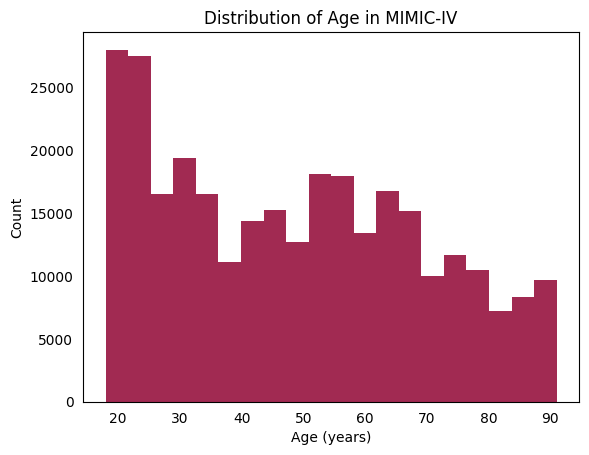

'\n연령 분포에서 볼 수 있듯이, 소아 환자의 데이터가 포함되어 있지 않다.\n'

In [13]:
# 환자별 연령분포

#let's see the distribution of age
plt.hist(patients['anchor_age'], bins=20, color='#a12a52')
plt.ylabel('Count')
plt.xlabel('Age (years)')
plt.title('Distribution of Age in MIMIC-IV')
plt.tick_params(left=False, bottom=False, top=False, right=False)
plt.show()

'''
연령 분포에서 볼 수 있듯이, 소아 환자의 데이터가 포함되어 있지 않다.
'''

In [14]:
# 성별 분포
patients['gender'].value_counts()

F    158553
M    141159
Name: gender, dtype: int64

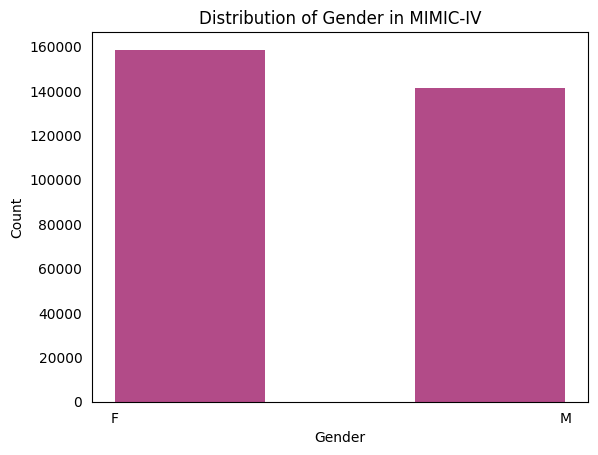

In [15]:
plt.hist(patients['gender'], bins=3, color='#b24b88')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.title('Distribution of Gender in MIMIC-IV')
plt.tick_params(left=False, bottom=False, top=False, right=False)
plt.show()

# 성별이 거의 균형을 이루고 있다.

In [16]:
# 'subject_id' 열로 환자 테이블과 입원 테이블을 병합
admits_patients = pd.merge(admits, patients, how='inner', on='subject_id')
admits_patients.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,race,edregtime,edouttime,hospital_expire_flag,died_at_the_hospital,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,EMERGENCY,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,...,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,0,F,52,2180,2014 - 2016,2180-09-09
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EMERGENCY,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,...,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0,0,F,52,2180,2014 - 2016,2180-09-09
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EMERGENCY,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,...,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0,0,F,52,2180,2014 - 2016,2180-09-09
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EMERGENCY,P30KEH,EMERGENCY ROOM,HOME,Medicaid,...,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0,0,F,52,2180,2014 - 2016,2180-09-09
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,OBSERVATION,P51VDL,EMERGENCY ROOM,NaN,Other,...,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0,0,F,19,2160,2008 - 2010,NaN


### Diagnoses_ICD Table

In [17]:
diag_icds.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


In [18]:
diag_icds.count()

subject_id     4756326
hadm_id        4756326
seq_num        4756326
icd_code       4756326
icd_version    4756326
dtype: int64

In [19]:
diag_icds.icd_version.value_counts()

9     2766877
10    1989449
Name: icd_version, dtype: int64

icd_code에는 버전 9와 버전 10의 두 가지 버전이 있다. 일반적으로 ICD-10 코드가 더 상세하지만 동일한 개념을 표현하기 때문에 ICD-9로 매핑하고 변환할 수 있다.

항목이 많은 데이터프레임을 다루고 어떤 경우든 더 빠른 테스트를 위해 나중에 크기를 줄여야 하므로 단순화를 위해 ICD9 코드를 사용한 진단만 고려한다.

icd9와 10을 변환하지 않아도 됨

In [20]:
diag_icds = diag_icds[diag_icds['icd_version'] == 9]
diag_icds.icd_version.value_counts()

9    2766877
Name: icd_version, dtype: int64

In [21]:
print('There are {} unique ICD9 codes in this dataset.'.format(diag_icds['icd_code'].value_counts().count()))

There are 9072 unique ICD9 codes in this dataset.


In [22]:
# Filter out E and V codes from ICD9 codes since processing will be done on the numeric first 3 values
diag_icds['recode'] = diag_icds['icd_code']
diag_icds['recode'] = diag_icds['recode'][~diag_icds['recode'].str.contains("[a-zA-Z]").fillna(False)]
diag_icds['recode'].fillna(value='999', inplace=True)

# Take in consideration just the first 3 integers of the ICD9 code
diag_icds['recode'] = diag_icds['recode'].str.slice(start=0, stop=3, step=1)
diag_icds['recode'] = diag_icds['recode'].astype(int)
diag_icds.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version,recode
0,10000032,22595853,1,5723,9,572
1,10000032,22595853,2,78959,9,789
2,10000032,22595853,3,5715,9,571
3,10000032,22595853,4,07070,9,70
4,10000032,22595853,5,496,9,496


In [23]:
# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390),
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin',
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    diag_icds['recode'] = np.where(diag_icds['recode'].between(cat_range[0],cat_range[1]), num, diag_icds['recode'])

# Convert integer to category name using diag_dict
diag_icds['super_category'] = diag_icds['recode'].replace(diag_dict)
diag_icds.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version,recode,super_category
0,10000032,22595853,1,5723,9,8,digestive
1,10000032,22595853,2,78959,9,15,misc
2,10000032,22595853,3,5715,9,8,digestive
3,10000032,22595853,4,07070,9,0,infectious
4,10000032,22595853,5,496,9,7,respiratory


각 입원에 대해 일반적으로 두 가지 이상의 진단이 있다. 한 카테고리에 대해 진단이 2개 이상인 경우가 많다.

각 입원에 대한 모든 진단을 강조하는 매트릭스를 만들 수 있다.
환자마다 입원 시 진단이 다를 수 있으므로 SUBJECT_ID에 대해서는 이 작업을 수행해서는 안 됨

In [24]:
# 각 입원별 진단 목록 생성
hadm_list = diag_icds.groupby('hadm_id')['super_category'].apply(list).reset_index()
hadm_list.head()

,hadm_id,super_category
0,20000019,"[infectious, genitourinary, congenital, genito..."
1,20000041,"[muscular, endocrine, injury, circulatory, end..."
2,20000057,"[muscular, muscular, injury, injury, injury, r..."
3,20000102,"[pregnancy, injury, injury]"
4,20000235,"[digestive, circulatory, digestive, genitourin..."


In [25]:
# 진단 목록을 병원 입원 항목 매트릭스로 변환
hadm_item = pd.get_dummies(hadm_list['super_category'].apply(pd.Series).stack()).sum(level=0)
hadm_item.head()

<ipython-input-25-bb8fa334a339>:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  hadm_item = pd.get_dummies(hadm_list['super_category'].apply(pd.Series).stack()).sum(level=0)


,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,1,1,1,0,3,2,1,2,0,0,0,0,0,0,0,1,0
1,0,1,0,1,3,0,0,4,0,0,1,0,0,0,0,0,0
2,1,1,0,0,1,0,0,7,0,1,5,0,4,0,1,2,0
3,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0
4,1,6,0,4,2,1,1,2,0,0,0,0,0,0,0,0,1


In [26]:
# HADM_ID로 다시 참여
hadm_item = hadm_item.join(hadm_list['hadm_id'], how="outer")

In [27]:
# 기본 데이터프레임과 병합
admits_patients_diag = pd.merge(admits_patients, hadm_item, how='inner', on='hadm_id')
admits_patients_diag.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,EMERGENCY,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,...,1,2,1,0,0,0,0,0,1,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EMERGENCY,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,...,1,1,1,0,0,0,0,0,1,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EMERGENCY,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,...,2,1,2,0,0,0,0,0,1,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EMERGENCY,P30KEH,EMERGENCY ROOM,HOME,Medicaid,...,3,2,2,0,0,0,0,0,1,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,OBSERVATION,P51VDL,EMERGENCY ROOM,NaN,Other,...,0,1,0,0,0,0,0,0,0,0


### ICUSTAYS Table
- ICUSTAYS 데이터는 입원 중 환자가 ICU에 있었는지 여부를 나타낸다. 이는 병원에서 환자의 사망을 판가름하는 요인이 될 수도 있다.

In [28]:
icustays.head()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266
1,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535
2,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032
3,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113
4,10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588


In [29]:
icustays['category'] = icustays['first_careunit']
icu_list = icustays.groupby('hadm_id')['category'].apply(list).reset_index()
icu_list.head()

,hadm_id,category
0,20000094,[Coronary Care Unit (CCU)]
1,20000147,[Coronary Care Unit (CCU)]
2,20000351,[Medical/Surgical Intensive Care Unit (MICU/SI...
3,20000808,"[Surgical Intensive Care Unit (SICU), Surgical..."
4,20001305,[Medical/Surgical Intensive Care Unit (MICU/SI...


In [30]:
icustays['first_careunit'].value_counts()

Medical Intensive Care Unit (MICU)                  15898
Medical/Surgical Intensive Care Unit (MICU/SICU)    12733
Cardiac Vascular Intensive Care Unit (CVICU)        11582
Surgical Intensive Care Unit (SICU)                 11161
Trauma SICU (TSICU)                                  8692
Coronary Care Unit (CCU)                             8311
Neuro Intermediate                                   2035
Neuro Surgical Intensive Care Unit (Neuro SICU)      1762
Neuro Stepdown                                       1007
Name: first_careunit, dtype: int64

In [31]:
# Create admission-ICU matrix
icu_item = pd.get_dummies(icu_list['category'].apply(pd.Series).stack()).sum(level=0)
icu_item[icu_item >= 1] = 1
icu_item = icu_item.join(icu_list['hadm_id'], how="outer")
icu_item.head()

<ipython-input-31-6d74a9f151b0>:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  icu_item = pd.get_dummies(icu_list['category'].apply(pd.Series).stack()).sum(level=0)


,Cardiac Vascular Intensive Care Unit (CVICU),Coronary Care Unit (CCU),Medical Intensive Care Unit (MICU),Medical/Surgical Intensive Care Unit (MICU/SICU),Neuro Intermediate,Neuro Stepdown,Neuro Surgical Intensive Care Unit (Neuro SICU),Surgical Intensive Care Unit (SICU),Trauma SICU (TSICU),hadm_id
0,0,1,0,0,0,0,0,0,0,20000094
1,0,1,0,0,0,0,0,0,0,20000147
2,0,0,0,1,0,0,0,0,0,20000351
3,0,0,0,0,0,0,0,1,0,20000808
4,0,0,0,1,0,0,0,0,0,20001305


In [32]:
# Merge ICU data with main dataFrame
final_df = admits_patients_diag.merge(icu_item, how='outer', on='hadm_id')

In [33]:
# Replace NaNs with 0
final_df['Cardiac Vascular Intensive Care Unit (CVICU)'].fillna(value=0, inplace=True)
final_df['Coronary Care Unit (CCU)'].fillna(value=0, inplace=True)
final_df['Medical Intensive Care Unit (MICU)'].fillna(value=0, inplace=True)
final_df['Medical/Surgical Intensive Care Unit (MICU/SICU)'].fillna(value=0, inplace=True)
final_df['Neuro Intermediate'].fillna(value=0, inplace=True)
final_df['Neuro Stepdown'].fillna(value=0, inplace=True)
final_df['Neuro Surgical Intensive Care Unit (Neuro SICU)'].fillna(value=0, inplace=True)
final_df['Surgical Intensive Care Unit (SICU)'].fillna(value=0, inplace=True)
final_df['Trauma SICU (TSICU)'].fillna(value=0, inplace=True)

In [34]:
final_df.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,skin,Cardiac Vascular Intensive Care Unit (CVICU),Coronary Care Unit (CCU),Medical Intensive Care Unit (MICU),Medical/Surgical Intensive Care Unit (MICU/SICU),Neuro Intermediate,Neuro Stepdown,Neuro Surgical Intensive Care Unit (Neuro SICU),Surgical Intensive Care Unit (SICU),Trauma SICU (TSICU)
0,10000032.0,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,EMERGENCY,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10000032.0,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EMERGENCY,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10000032.0,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EMERGENCY,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10000032.0,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EMERGENCY,P30KEH,EMERGENCY ROOM,HOME,Medicaid,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10000068.0,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,OBSERVATION,P51VDL,EMERGENCY ROOM,NaN,Other,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# save this version of the dataframe to a csv. It will be used as baseline for our prediction tasks
# final_df.to_csv('/content/drive/MyDrive/DAHS LAB/final_df.csv')

## 3. Data Analytic

In [36]:
# final_df = pd.read_csv('admits_patients_diag.csv')

#convert dates
#final_df.admittime = pd.to_datetime(final_df.admittime)
#final_df.dischtime = pd.to_datetime(final_df.dischtime)
#final_df.deathtime = pd.to_datetime(final_df.deathtime)

final_df.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,skin,Cardiac Vascular Intensive Care Unit (CVICU),Coronary Care Unit (CCU),Medical Intensive Care Unit (MICU),Medical/Surgical Intensive Care Unit (MICU/SICU),Neuro Intermediate,Neuro Stepdown,Neuro Surgical Intensive Care Unit (Neuro SICU),Surgical Intensive Care Unit (SICU),Trauma SICU (TSICU)
0,10000032.0,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaT,EMERGENCY,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10000032.0,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaT,EMERGENCY,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10000032.0,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaT,EMERGENCY,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10000032.0,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaT,EMERGENCY,P30KEH,EMERGENCY ROOM,HOME,Medicaid,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10000068.0,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaT,OBSERVATION,P51VDL,EMERGENCY ROOM,NaN,Other,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303577 entries, 0 to 303576
Data columns (total 48 columns):
 #   Column                                            Non-Null Count   Dtype         
---  ------                                            --------------   -----         
 0   subject_id                                        276803 non-null  float64       
 1   hadm_id                                           303577 non-null  int64         
 2   admittime                                         276803 non-null  datetime64[ns]
 3   dischtime                                         276803 non-null  datetime64[ns]
 4   deathtime                                         5216 non-null    datetime64[ns]
 5   admission_type                                    276803 non-null  object        
 6   admit_provider_id                                 276803 non-null  object        
 7   admission_location                                276803 non-null  object        
 8   discharge_loca

In [38]:
# timedelta 유형을 float 'days', 하루 86400초로 변환하는 LOS 속성을 생성합니다.
final_df['los'] = (final_df['dischtime'] - final_df['admittime']).dt.total_seconds()/86400

# LOS 계산 확인
final_df[['admittime', 'dischtime', 'los']].head()

,admittime,dischtime,los
0,2180-05-06 22:23:00,2180-05-07 17:15:00,0.786111
1,2180-06-26 18:27:00,2180-06-27 18:49:00,1.015278
2,2180-08-05 23:44:00,2180-08-07 17:50:00,1.754167
3,2180-07-23 12:35:00,2180-07-25 17:55:00,2.222222
4,2160-03-03 23:16:00,2160-03-04 06:26:00,0.298611


In [39]:
# 음수로 LOS를 제거합니다.
final_df = final_df[final_df['los'] > 0]
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276703 entries, 0 to 276802
Data columns (total 49 columns):
 #   Column                                            Non-Null Count   Dtype         
---  ------                                            --------------   -----         
 0   subject_id                                        276703 non-null  float64       
 1   hadm_id                                           276703 non-null  int64         
 2   admittime                                         276703 non-null  datetime64[ns]
 3   dischtime                                         276703 non-null  datetime64[ns]
 4   deathtime                                         5166 non-null    datetime64[ns]
 5   admission_type                                    276703 non-null  object        
 6   admit_provider_id                                 276703 non-null  object        
 7   admission_location                                276703 non-null  object        
 8   discharge_loca

In [40]:
final_df.died_at_the_hospital.value_counts()

0.0    271537
1.0      5166
Name: died_at_the_hospital, dtype: int64

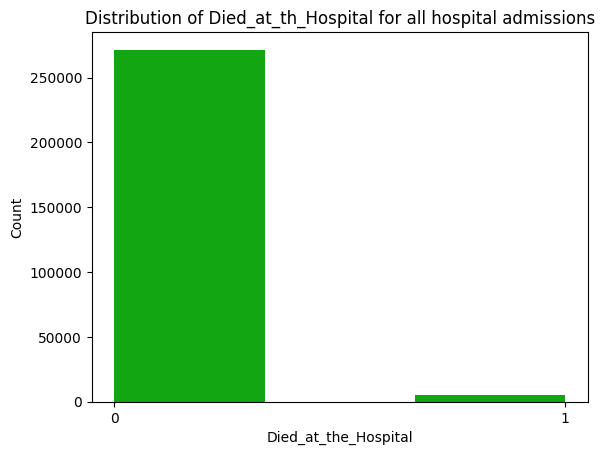

In [41]:
# Plot LOS Distribution
plt.hist(final_df['died_at_the_hospital'], bins=3, color = '#11a612')
plt.title('Distribution of Died_at_th_Hospital for all hospital admissions')
plt.ylabel('Count')
plt.xlabel('Died_at_the_Hospital')
plt.xticks(range(0,2))
plt.show();

In [42]:
print('Number of positive samples:', (final_df.died_at_the_hospital == 1).sum()) # died at hospital
print('Number of negative samples:',  (final_df.died_at_the_hospital == 0).sum()) # not died at hospital
print('Total samples:', len(final_df))

Number of positive samples: 5166
Number of negative samples: 271537
Total samples: 276703


### Died_at_the_Hospital VS Race


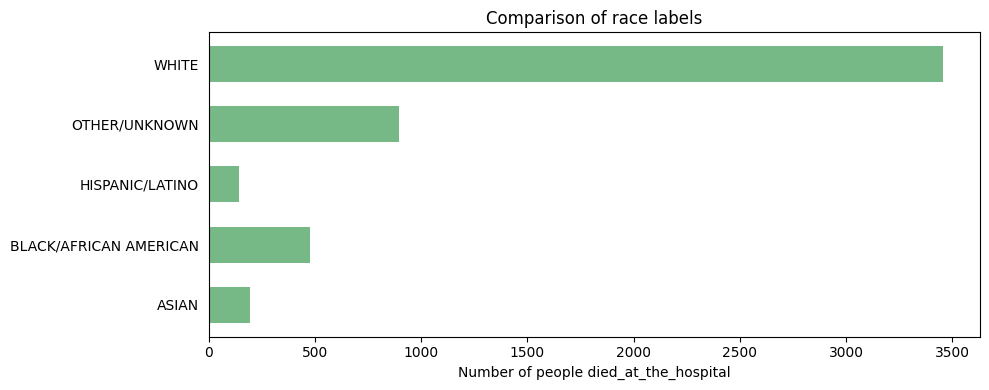

In [43]:
# Re-usable plotting function
def plot_los_groupby(variable, size=(7,4)):
    results = final_df[[variable, 'died_at_the_hospital']].groupby(variable).sum().reset_index()
    values = list(results['died_at_the_hospital'].values)
    labels = list(results[variable].values)

    fig, ax = plt.subplots(figsize=size)
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, color = '#55a868', alpha=0.8)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Number of people died_at_the_hospital')
    ax.tick_params(left=False, top=False, right=False)
    ax.set_title('Comparison of {} labels'.format(variable))
    plt.tight_layout()
    plt.show();

plot_los_groupby('race', size=(10,4))

아시아인과 히스패닉/라틴계 사람들은 일반적으로 병원에 입원하는 동안 사망하는 비율이 적다.

### Died_at_the_Hospital VS Admission_Type


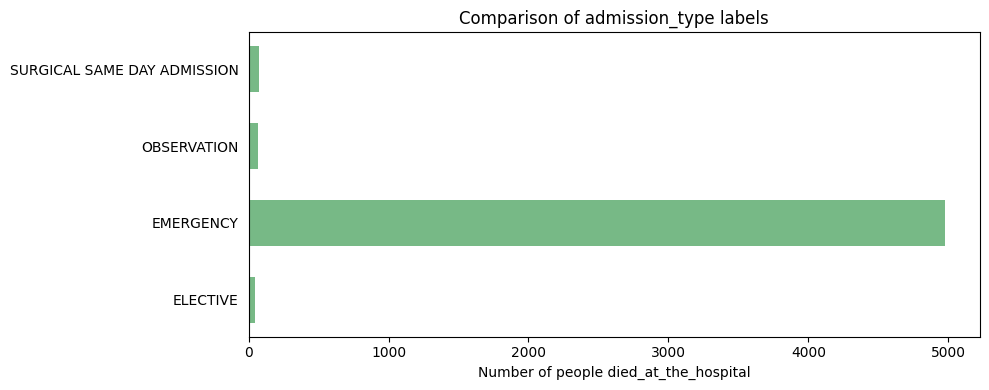

In [44]:
plot_los_groupby('admission_type', size=(10,4))

사망자가 가장 많은 것은 응급실에 입원한 환자들이다.

### Died_at_the_Hospital VS Age


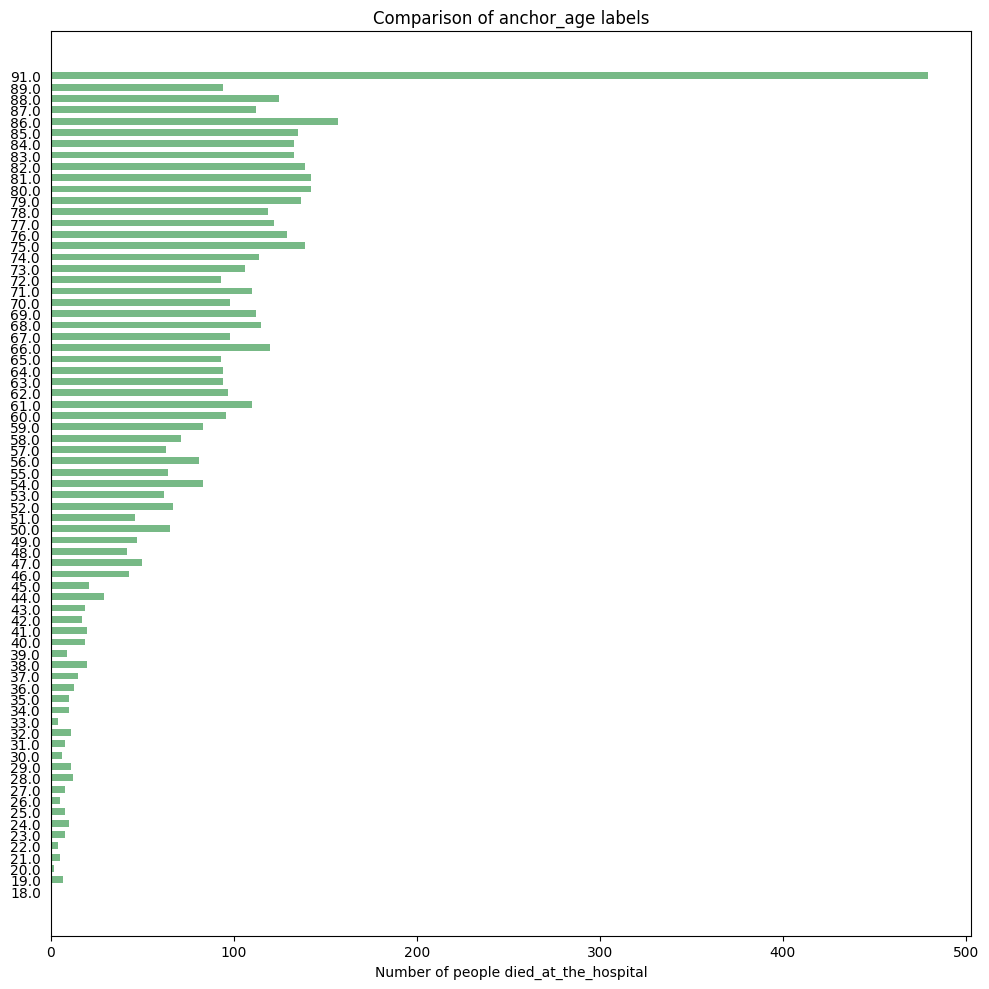

In [45]:
plot_los_groupby('anchor_age', size=(10,10))


모든 연령을 신생아, 젊은 성인, 중년 및 노인 범주로 변환하는 것이 유용할 것이.

In [46]:
age_ranges = [(0, 13), (14, 36), (37, 56), (57, 100)]
for num, cat_range in enumerate(age_ranges):
    final_df['anchor_age'] = np.where(final_df['anchor_age'].between(cat_range[0],cat_range[1]), num, final_df['anchor_age'])

age_dict = {0: 'NEWBORN', 1: 'YOUNG_ADULT', 2: 'MIDDLE_ADULT', 3: 'SENIOR'}
final_df['anchor_age'] = final_df['anchor_age'].replace(age_dict)
final_df.anchor_age.value_counts()

SENIOR          145256
MIDDLE_ADULT     81886
YOUNG_ADULT      49561
Name: anchor_age, dtype: int64

### Analyze the diagnosis in correlation to our target LOS.

target LOS와 연관하여 진단을 분석

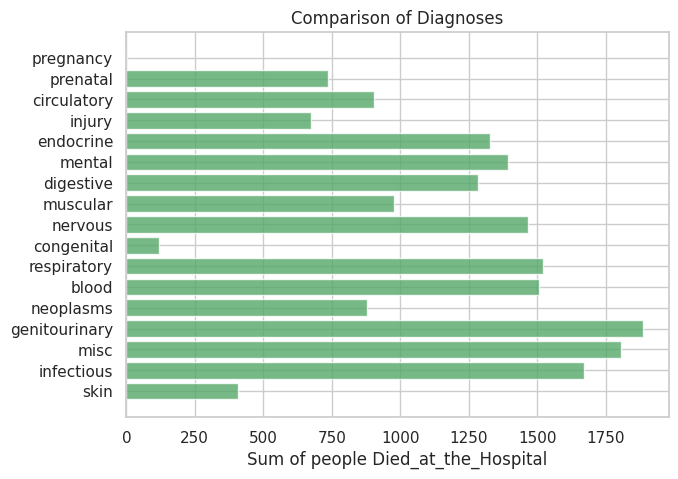

In [47]:
import seaborn as sns

# Look at the median LOS by diagnosis category
diag_cat_list = ['skin', 'infectious',  'misc', 'genitourinary', 'neoplasms', 'blood', 'respiratory',
                  'congenital','nervous', 'muscular', 'digestive', 'mental', 'endocrine', 'injury',
                 'circulatory', 'prenatal',  'pregnancy']

results = []
for variable in diag_cat_list:
    results.append(admits_patients_diag[[variable, 'died_at_the_hospital']].groupby(variable).sum().reset_index().values[1][1])


sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(7,5))
ind = range(len(results))
ax.barh(ind, results, color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(diag_cat_list)
ax.set_xlabel('Sum of people Died_at_the_Hospital')
ax.tick_params(left=False, right=False, top=False)
ax.set_title('Comparison of Diagnoses'.format(variable))
plt.show();

- 병원에서 가장 많은 사망자가 발생한 경우는 비뇨생식기 질환(genitourinary)으로 진단받은 사람들이다.
- 병원에서 가장 낮은 사망자 수는 임신(pregnancy) 중인 사람들이다.

## 4. Data Cleaning

In [48]:
final_df.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,Cardiac Vascular Intensive Care Unit (CVICU),Coronary Care Unit (CCU),Medical Intensive Care Unit (MICU),Medical/Surgical Intensive Care Unit (MICU/SICU),Neuro Intermediate,Neuro Stepdown,Neuro Surgical Intensive Care Unit (Neuro SICU),Surgical Intensive Care Unit (SICU),Trauma SICU (TSICU),los
0,10000032.0,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaT,EMERGENCY,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.786111
1,10000032.0,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaT,EMERGENCY,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.015278
2,10000032.0,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaT,EMERGENCY,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.754167
3,10000032.0,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaT,EMERGENCY,P30KEH,EMERGENCY ROOM,HOME,Medicaid,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.222222
4,10000068.0,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaT,OBSERVATION,P51VDL,EMERGENCY ROOM,NaN,Other,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.298611


In [49]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276703 entries, 0 to 276802
Data columns (total 49 columns):
 #   Column                                            Non-Null Count   Dtype         
---  ------                                            --------------   -----         
 0   subject_id                                        276703 non-null  float64       
 1   hadm_id                                           276703 non-null  int64         
 2   admittime                                         276703 non-null  datetime64[ns]
 3   dischtime                                         276703 non-null  datetime64[ns]
 4   deathtime                                         5166 non-null    datetime64[ns]
 5   admission_type                                    276703 non-null  object        
 6   admit_provider_id                                 276703 non-null  object        
 7   admission_location                                276703 non-null  object        
 8   discharge_loca

In [50]:
# Drop unused or no longer needed columns
final_df.drop(columns=['admit_provider_id', 'admission_location', 'discharge_location', 'language', 'marital_status', 'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime','dod', 'los'], inplace=True)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276703 entries, 0 to 276802
Data columns (total 37 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   admission_type                                    276703 non-null  object 
 1   insurance                                         276703 non-null  object 
 2   race                                              276703 non-null  object 
 3   edregtime                                         192018 non-null  object 
 4   edouttime                                         192018 non-null  object 
 5   hospital_expire_flag                              276703 non-null  float64
 6   died_at_the_hospital                              276703 non-null  float64
 7   gender                                            276703 non-null  object 
 8   anchor_age                                        276703 non-null  object 
 9   anch

In [51]:
final_df.drop(columns=['edregtime',	'edouttime', 'anchor_year_group'], inplace=True)
final_df.info()
'''
'admit_provider_id', 'admission_location', 'discharge_location', 'language', 'marital_status''edregtime',	'edouttime
'''

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276703 entries, 0 to 276802
Data columns (total 34 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   admission_type                                    276703 non-null  object 
 1   insurance                                         276703 non-null  object 
 2   race                                              276703 non-null  object 
 3   hospital_expire_flag                              276703 non-null  float64
 4   died_at_the_hospital                              276703 non-null  float64
 5   gender                                            276703 non-null  object 
 6   anchor_age                                        276703 non-null  object 
 7   anchor_year                                       276703 non-null  float64
 8   blood                                             276703 non-null  float64
 9   circ

"\n'admit_provider_id', 'admission_location', 'discharge_location', 'language', 'marital_status''edregtime',\t'edouttime\n"

In [52]:
# 범주형 변수에 대한 더미 열을 만듭니다.
prefix_cols = ['ADM', 'INS', 'ETH', 'AGE']
dummy_cols = ['admission_type', 'insurance','race', 'anchor_age']
df_cleaned = pd.get_dummies(final_df, prefix=prefix_cols, columns=dummy_cols)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276703 entries, 0 to 276802
Data columns (total 45 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   hospital_expire_flag                              276703 non-null  float64
 1   died_at_the_hospital                              276703 non-null  float64
 2   gender                                            276703 non-null  object 
 3   anchor_year                                       276703 non-null  float64
 4   blood                                             276703 non-null  float64
 5   circulatory                                       276703 non-null  float64
 6   congenital                                        276703 non-null  float64
 7   digestive                                         276703 non-null  float64
 8   endocrine                                         276703 non-null  float64
 9   geni

In [53]:
# Drop rows that contain NaN values
df_cleaned.dropna(axis=0, inplace=True)

In [54]:
# Check for any remaining NaNs
df_cleaned.isnull().values.sum()

0

In [55]:
df_cleaned.isnull().sum()

hospital_expire_flag                                0
died_at_the_hospital                                0
gender                                              0
anchor_year                                         0
blood                                               0
circulatory                                         0
congenital                                          0
digestive                                           0
endocrine                                           0
genitourinary                                       0
infectious                                          0
injury                                              0
mental                                              0
misc                                                0
muscular                                            0
neoplasms                                           0
nervous                                             0
pregnancy                                           0
prenatal                    

In [56]:
# Convert gender into numeric boolean attribute
df_cleaned['gender'].replace({'M': 0, 'F':1}, inplace=True)
df_cleaned.head()

,hospital_expire_flag,died_at_the_hospital,gender,anchor_year,blood,circulatory,congenital,digestive,endocrine,genitourinary,...,INS_Medicare,INS_Other,ETH_ASIAN,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC/LATINO,ETH_OTHER/UNKNOWN,ETH_WHITE,AGE_MIDDLE_ADULT,AGE_SENIOR,AGE_YOUNG_ADULT
0,0.0,0.0,1,2180.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0,1,0,0,0,0,1,1,0,0
1,0.0,0.0,1,2180.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,1,1,0,0
2,0.0,0.0,1,2180.0,0.0,0.0,0.0,1.0,2.0,0.0,...,0,0,0,0,0,0,1,1,0,0
3,0.0,0.0,1,2180.0,0.0,1.0,0.0,1.0,2.0,0.0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0.0,1,2160.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,1,0,0,1


In [57]:
df_cleaned = df_cleaned.astype(int)


In [58]:
df_cleaned.isnull().values.sum()

0

## 5. Prediction Model


In [59]:
# Target Variable (died_at_the_hospital)
HOSP_MORT = df_cleaned['died_at_the_hospital'].values
# Prediction Features
features = df_cleaned.drop(columns=['died_at_the_hospital'])

In [60]:
from sklearn.model_selection import train_test_split

# Split into training set 80% and test set 20%
X_train, X_test, y_train, y_test = train_test_split(features, HOSP_MORT, test_size = 0.2, random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 221362 samples.
Testing set has 55341 samples.


In [61]:
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Regression models used from scikit-learn for comparison
models = [GradientBoostingRegressor(random_state = 0),
          LinearRegression(),
          KNeighborsRegressor(),
          RandomForestRegressor(random_state = 0)]

results = {}

for model in models:
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train)

    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)

    # Grab model name and store results associated with model
    name = str(model).split("(")[0]

    results[name] = r2_score(y_test, y_test_preds)
    print('{} done.'.format(name))

GradientBoostingRegressor done.
LinearRegression done.
KNeighborsRegressor done.
RandomForestRegressor done.


Text(0.5, 1.0, 'Comparison of Regression Models')

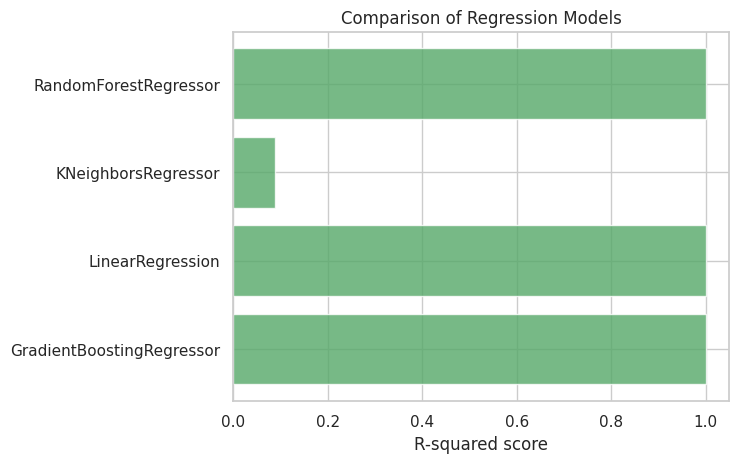

In [62]:
# R2 score results
fig, ax = plt.subplots()
ind = range(len(results))
ax.barh(ind, list(results.values()), align='center',
        color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(results.keys())
ax.set_xlabel('R-squared score')
ax.tick_params(left=False, top=False, right=False)
ax.set_title('Comparison of Regression Models')


In [63]:
# GradientBoostingRegressor는 병원 내 사망률 예측 모델로 사용됩니다.
# GradientBoostingRegressor가 LOS 예측 모델로 사용됩니다.

reg_model = GradientBoostingRegressor(random_state=0)
reg_model.fit(X_train, y_train)
y_test_preds = reg_model.predict(X_test)
r2_not_refined = r2_score(y_test, y_test_preds)
print("R2 score is: {:2f}".format(r2_not_refined))

R2 score is: 0.999958


## 6. Parameter Tuning

In [64]:
from sklearn.model_selection import GridSearchCV

# Assuming 'features' and 'HOSP_MORT' are already defined and are your predictors and target variable, respectively.

# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    HOSP_MORT,
                                                    test_size=0.20,
                                                    random_state=42)

# Set the parameters by cross-validation
tuned_parameters = [{'n_estimators': [200, 300],
                     'max_depth': [3, 4],
                     'loss': ['squared_error', 'absolute_error']}]

# Create and fit a gradient boosting regressor model, testing each parameter set
reg_model = GradientBoostingRegressor()
grid = GridSearchCV(reg_model, tuned_parameters, cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

# Retrieve the best model from grid search
reg_model_optimized = grid.best_estimator_

# Summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
0.9997574698304755
GradientBoostingRegressor(loss='absolute_error', n_estimators=200)


In [65]:
y_test_preds = reg_model_optimized.predict(X_test)
r2_optimized = r2_score(y_test, y_test_preds)
print("Optimized R2 score is: {:2f}".format(r2_optimized))

Optimized R2 score is: 0.997856


In [66]:
print('Parameter tuning improved R2 score by {:.4f}'.format(r2_optimized-r2_not_refined))

Parameter tuning improved R2 score by -0.0021


## 7. Model evaluation and result Discussion


In [67]:
feature_imp = pd.DataFrame(reg_model_optimized.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_imp.head(20)

,importance
hospital_expire_flag,9.999984e-01
injury,1.310451e-06
Surgical Intensive Care Unit (SICU),2.771126e-07
INS_Medicaid,0.000000e+00
Neuro Stepdown,0.000000e+00
Neuro Surgical Intensive Care Unit (Neuro SICU),0.000000e+00
Trauma SICU (TSICU),0.000000e+00
ADM_ELECTIVE,0.000000e+00
ADM_EMERGENCY,0.000000e+00
ADM_OBSERVATION,0.000000e+00


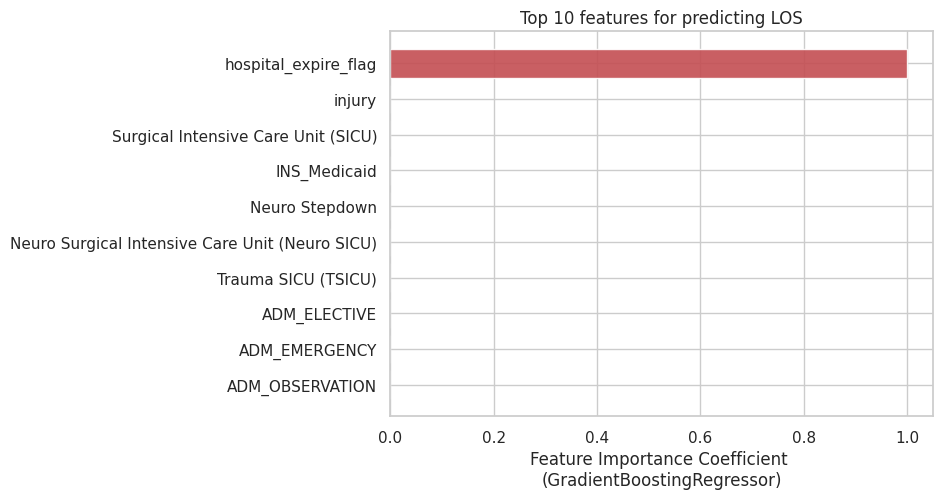

In [68]:
#Let's plot the top-10 feature importance
feature_imp.index[0:10].tolist()
# Plot feature importance
fig, ax = plt.subplots(figsize=(7, 5))
ind = range(0,10)
ax.barh(ind, feature_imp['importance'].values[0:10],
        align='center', color='#c44e52', alpha=0.9)
ax.set_yticks(ind)
ax.set_yticklabels(feature_imp.index[0:10].tolist())
ax.tick_params(left=False, top=False, right=False)
ax.set_title("Top 10 features for predicting LOS")
ax.set_xlabel('Feature Importance Coefficient \n(GradientBoostingRegressor)')
plt.gca().invert_yaxis()